In [ ]:
!pip install imbalanced-ensemble
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from imbalanced_ensemble.ensemble import SMOTEBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
import time


%matplotlib inline

## Data Loading

PIMA Dataset

In [ ]:
def load_pima_dataset():
  data = pd.read_csv('diabetes.csv')
  pd.value_counts(data['Outcome']).plot.bar()
  plt.title('Pima Dataset')
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  plt.show()

  X = data.drop(data.columns.values[-1:],axis=1)
  y = data.drop(data.columns.values[:-1],axis=1)

  return X.to_numpy(), y.to_numpy()

Credit Card Dataset

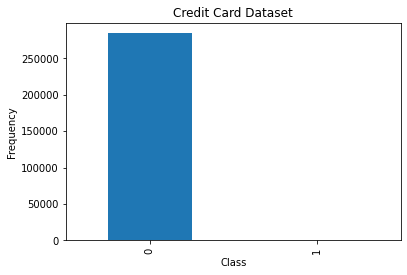

(array([[-1.35980713e+00, -7.27811733e-02,  2.53634674e+00, ...,
         -1.89114844e-01,  1.33558377e-01, -2.10530535e-02],
        [ 1.19185711e+00,  2.66150712e-01,  1.66480113e-01, ...,
          1.25894532e-01, -8.98309914e-03,  1.47241692e-02],
        [-1.35835406e+00, -1.34016307e+00,  1.77320934e+00, ...,
         -1.39096572e-01, -5.53527940e-02, -5.97518406e-02],
        ...,
        [ 1.91956501e+00, -3.01253846e-01, -3.24963981e+00, ...,
         -8.73705959e-02,  4.45477214e-03, -2.65608286e-02],
        [-2.40440050e-01,  5.30482513e-01,  7.02510230e-01, ...,
          5.46668462e-01,  1.08820735e-01,  1.04532821e-01],
        [-5.33412522e-01, -1.89733337e-01,  7.03337367e-01, ...,
         -8.18267121e-01, -2.41530880e-03,  1.36489143e-02]]), array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [ ]:
def load_credit_card_dataset():
  data = pd.read_csv('creditcard.csv')
  pd.value_counts(data['Class']).plot.bar()
  plt.title('Credit Card Dataset')
  plt.xlabel('Class')
  plt.ylabel('Frequency')
  plt.show()
  data = data.drop(['Time', 'Amount'], axis=1)

  X = data.drop(data.columns.values[-1:],axis=1)
  y = data.drop(data.columns.values[:-1],axis=1)

  return X.to_numpy(),y.to_numpy()

load_credit_card_dataset()

Synthetic Datasets

In [ ]:
def load_synthetic_dataset(num_samples=100, num_features=4, num_classes=2, weights_list=[0.9, 0.1], random_state=0, test_size=0.2):
  X,y = make_classification(n_samples=num_samples,n_features=num_features,n_classes=num_classes,weights=weights_list,random_state=random_state)

  plt.scatter(X[:,0][y==1],X[:,1][y==1],c='g',marker='X')
  plt.scatter(X[:,0][y==0],X[:,1][y==0],c='r',marker='.')
  plt.show()

  y = np.array([[float(i)] for i in y])

  return X, y

## Evaluation Metrics

In [ ]:
def get_evaluation_metrics(X_test, y_test, y_predict):
  fn = len(y_test[(y_predict==0) & (y_test==1)])
  tp = len(y_predict[(y_predict==1) & (y_test==1)])
  fp = len(y_predict[(y_predict==1) & (y_test==0)])
  tn = len(y_predict[(y_predict==0) & (y_test==0)])
  majority_acc = len(y_test[(y_predict==1) & (y_test==1)])/(len(y_test[(y_predict==0) & (y_test==1)])+len(y_predict[(y_predict==1) & (y_test==1)]))
  minority_acc = len(y_test[(y_predict==0) & (y_test==0)])/(len(y_test[(y_predict==1) & (y_test==0)])+len(y_predict[(y_predict==0) & (y_test==0)]))

  return fn, tp, fp, tn, majority_acc, minority_acc

## SMOTE

In [ ]:
def get_knn(X, y, y_minority, k):
  neighbours = []
  for index_1 in range(len(X[:][y==y_minority])):
    neighbours.append([])
    for index_2 in range(len(X[:][y==y_minority])):
      if index_2 != index_1:
        dist = np.sum(np.square(X[:][y==y_minority][index_1]-X[:][y==y_minority][index_2]))
        neighbours[index_1].append((dist, index_2))
    neighbours[index_1].sort()
  neighbours = np.array(neighbours)
  k_neighbours = neighbours[:, :k]
  return k_neighbours

In [ ]:
def nn_vect_select(X, y, y_minority, nnarray, k, os_percent):
  init_size = len(X[:][y==y_minority])
  factor = os_percent // 100
  for index_1 in range(init_size):
    neigh_nums = random.sample(range(0, k), factor)
    for i in neigh_nums:
      index_2 = int(nnarray[index_1][i][1])
      ratio = random.random()
      new_vals = X[:][y==y_minority][index_1] + ratio * (X[:][y==y_minority][index_2] - X[:][y==y_minority][index_1])
      X = np.append(X,[new_vals],axis=0)
      y = np.append(y,[y_minority])
  return X, y

In [ ]:
def apply_smote(X, y, y_minority, test_size=0.3, random_state=0, os_percent=200, k=5):
  y = y.ravel()

  nnarray = get_knn(X, y, y_minority, k)
  X, y = nn_vect_select(X, y, y_minority, nnarray, k, os_percent)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  clf = KNeighborsClassifier()
  clf.fit(X_train,y_train)
  y_predict = clf.predict(X_test)

  y_scores = clf.predict_proba(X_test)
  fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
  roc_auc = auc(fpr, tpr)

  fn, tp, fp, tn, majority_acc, minority_acc = get_evaluation_metrics(X_test, y_test, y_predict)

  print('Over-sampling %: ', os_percent)
  print('Precision: ', tp/(tp+fp))
  print('Recall: ', tp/(tp+fn))
  # print('Accuracy: ', (tp+tn)/(tp+fp+tn+fn))

  print()

  return X, y, fpr, tpr, roc_auc

## SMOTEBoost

In [ ]:
def apply_smote_boost(X, y, y_minority, test_size=0.3, random_state=0):
  y = y.ravel()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
  sm_boost = SMOTEBoostClassifier(random_state=random_state)
  sm_boost.fit(X_train, y_train)  
  y_predict = sm_boost.predict(X_test)

  y_scores = sm_boost.decision_function(X_test)
  fpr, tpr, threshold = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)

  fn, tp, fp, tn, majority_acc, minority_acc = get_evaluation_metrics(X_test, y_test, y_predict)
  print()
  print('Precision: ', tp/(tp+fp))
  print('Recall: ', tp/(tp+fn))
  # print('Accuracy: ', (tp+tn)/(tp+fp+tn+fn))
  return fpr, tpr, roc_auc

## Analysis

In [ ]:
oversampling_percentage = [0,100,200,300]
colours = ['b', 'g', 'y', 'r']

In [ ]:
def evaluate_smote(X, y, test_size=0.3, random_state=0, os_percent=200, k=5):
  newX, newy, fpr, tpr, roc_auc = apply_smote(X, y, 1, test_size=test_size, os_percent=os_percent, k=k)
  return newX, newy, fpr, tpr, roc_auc

In [ ]:
def evaluate_smote_boost(X, y, test_size=0.3, random_state=0):
  fpr, tpr, roc_auc = apply_smote_boost(X, y, 1, test_size=test_size)
  return fpr, tpr, roc_auc

#### SMOTE+KNN on Pima

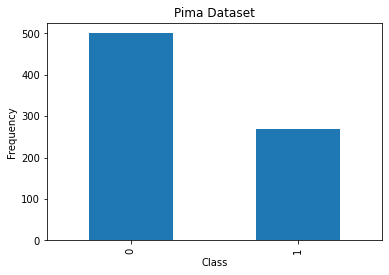

Over-sampling %:  0
Precision:  0.6290322580645161
Recall:  0.527027027027027

Over-sampling %:  100
Precision:  0.7068062827225131
Recall:  0.8653846153846154

Over-sampling %:  200
Precision:  0.7777777777777778
Recall:  0.9545454545454546

Over-sampling %:  300
Precision:  0.7938931297709924
Recall:  0.9719626168224299



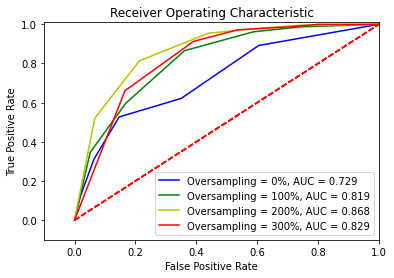

In [ ]:
X, y = load_pima_dataset()
for i in range(0, len(oversampling_percentage)):
  plt.title('Receiver Operating Characteristic')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.1,1.0])
  plt.ylim([-0.1,1.01])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  
  newX, newY, fpr, tpr, roc_auc = evaluate_smote(X, y, os_percent=oversampling_percentage[i])

  plt.plot(fpr, tpr, colours[i],label='Oversampling = %d%%, AUC = %0.3f'% (oversampling_percentage[i], roc_auc))

plt.legend()
plt.show()

#### SMOTEBoost on Pima

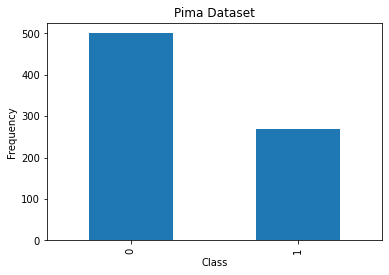


Precision:  0.6619718309859155
Recall:  0.6351351351351351





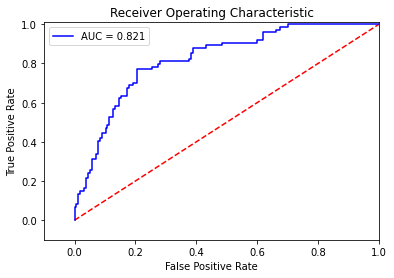

In [ ]:
X, y = load_pima_dataset()
plt.title('Receiver Operating Characteristic')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
fpr, tpr, roc_auc = evaluate_smote_boost(X, y)

plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% (roc_auc))
print('\n\n')

plt.legend()
plt.show()

#### SMOTEBoost on Credit Fraud

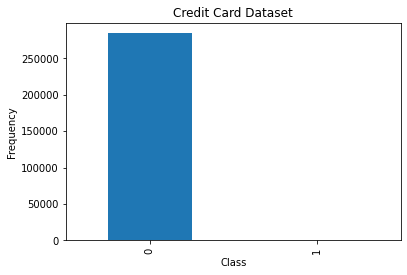


Precision:  0.0711484593837535
Recall:  0.8639455782312925





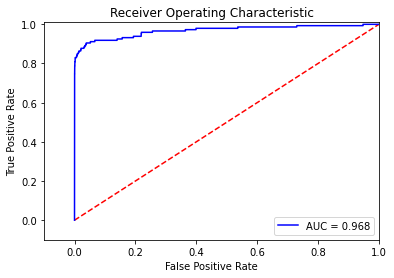

In [172]:
X, y = load_credit_card_dataset()
plt.title('Receiver Operating Characteristic')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
fpr, tpr, roc_auc = evaluate_smote_boost(X, y)

plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% (roc_auc))
print('\n\n')

plt.legend()
plt.show()

#### SMOTE+KNN on Synthetic Data

In [ ]:
number_samples = [1000]
oversampling_percentage = [0,100,200,300]
ir = [5, 10, 50]

Imbalance Ratio:  5
Number of Samples:  1000


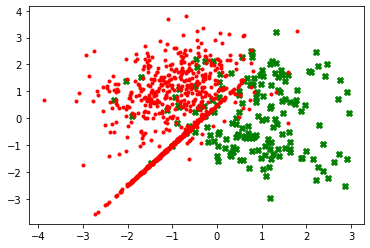

Over-sampling %:  0
Precision:  0.7948717948717948
Recall:  0.6739130434782609

Over-sampling %:  100
Precision:  0.9156626506024096
Recall:  0.7378640776699029

Over-sampling %:  200
Precision:  0.863013698630137
Recall:  0.8344370860927153

Over-sampling %:  300
Precision:  0.8923076923076924
Recall:  0.8743718592964824



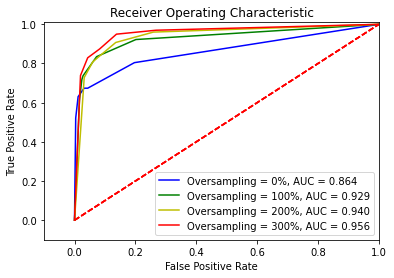

Imbalance Ratio:  10
Number of Samples:  1000


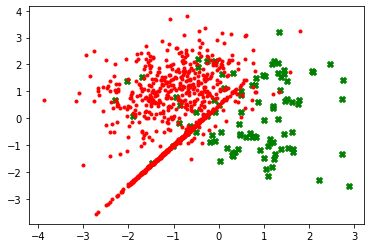

Over-sampling %:  0
Precision:  0.8
Recall:  0.5925925925925926

Over-sampling %:  100
Precision:  0.8181818181818182
Recall:  0.6666666666666666

Over-sampling %:  200
Precision:  0.8571428571428571
Recall:  0.7764705882352941

Over-sampling %:  300
Precision:  0.8725490196078431
Recall:  0.7672413793103449



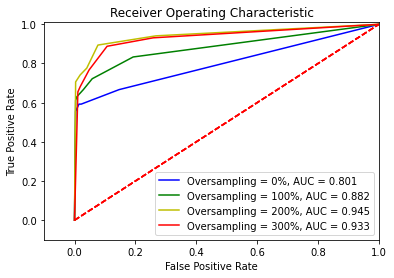

Imbalance Ratio:  50
Number of Samples:  1000


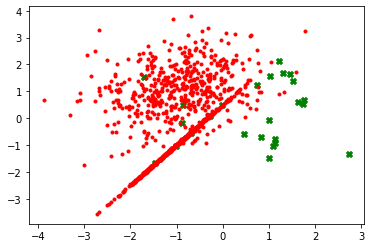

Over-sampling %:  0
Precision:  0.5
Recall:  0.16666666666666666

Over-sampling %:  100
Precision:  0.8333333333333334
Recall:  0.625

Over-sampling %:  200
Precision:  0.8333333333333334
Recall:  0.75

Over-sampling %:  300
Precision:  0.9259259259259259
Recall:  0.7142857142857143



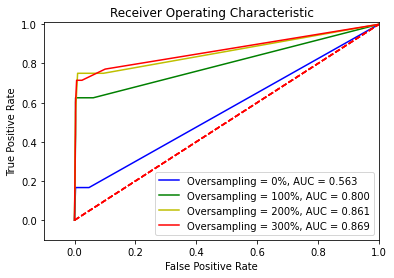

In [ ]:
for j in range(len(ir)):
  print('Imbalance Ratio: ', ir[j])
  for num_samp in number_samples:
    print('Number of Samples: ', num_samp)
    X, y = load_synthetic_dataset(num_samples=num_samp, weights_list=[ir[j]/(ir[j]+1), 1/(ir[j]+1)], random_state=2)
    for i in range(0, len(oversampling_percentage)):
      plt.title('Receiver Operating Characteristic')
      plt.plot([0,1],[0,1],'r--')
      plt.xlim([-0.1,1.0])
      plt.ylim([-0.1,1.01])
      plt.ylabel('True Positive Rate')
      plt.xlabel('False Positive Rate')
      newX, newy, fpr, tpr, roc_auc = evaluate_smote(X, y, os_percent=oversampling_percentage[i])
      plt.plot(fpr, tpr, colours[i],label='Oversampling = %d%%, AUC = %0.3f'% (oversampling_percentage[i], roc_auc))

    plt.legend()
    plt.show()

Imbalance Ratio:  5
Number of Samples:  1000


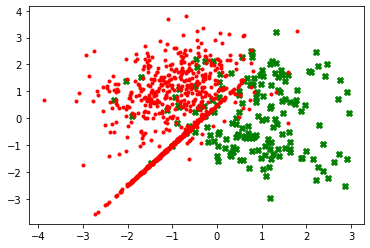

Over-sampling %:  0
Precision:  0.7948717948717948
Recall:  0.6739130434782609

Over-sampling %:  0


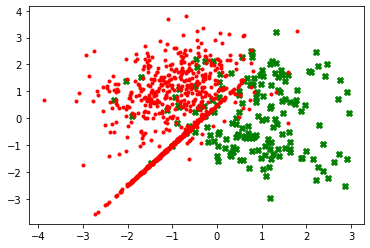

Over-sampling %:  100
Precision:  0.872093023255814
Recall:  0.7281553398058253

Over-sampling %:  100


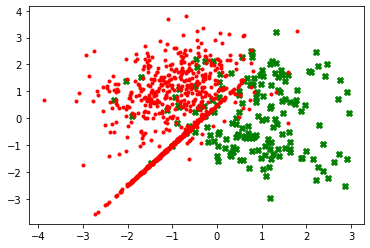

Over-sampling %:  200
Precision:  0.8571428571428571
Recall:  0.8741721854304636

Over-sampling %:  200


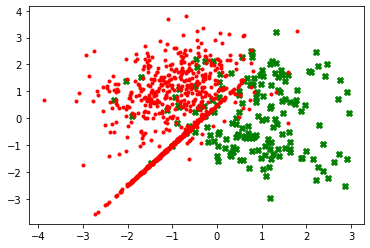

Over-sampling %:  300
Precision:  0.8984771573604061
Recall:  0.8894472361809045

Over-sampling %:  300


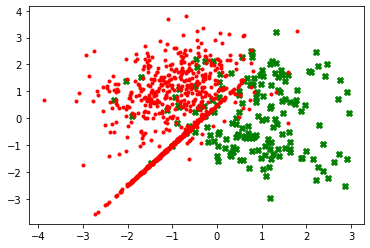

Imbalance Ratio:  10
Number of Samples:  1000


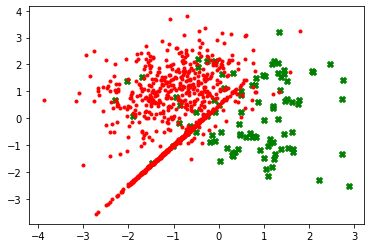

Over-sampling %:  0
Precision:  0.8
Recall:  0.5925925925925926

Over-sampling %:  0


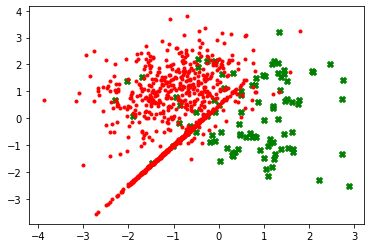

Over-sampling %:  100
Precision:  0.8636363636363636
Recall:  0.7037037037037037

Over-sampling %:  100


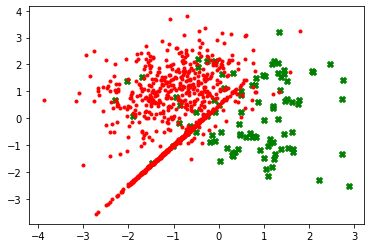

Over-sampling %:  200
Precision:  0.8375
Recall:  0.788235294117647

Over-sampling %:  200


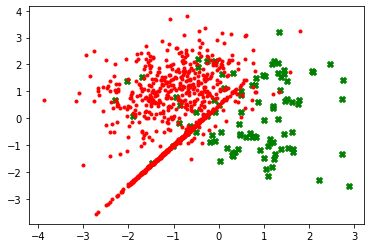

Over-sampling %:  300
Precision:  0.8557692307692307
Recall:  0.7672413793103449

Over-sampling %:  300


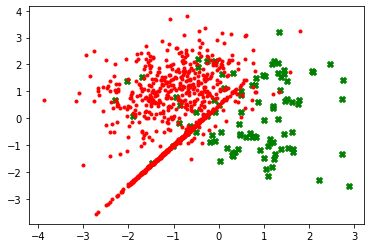

Imbalance Ratio:  50
Number of Samples:  1000


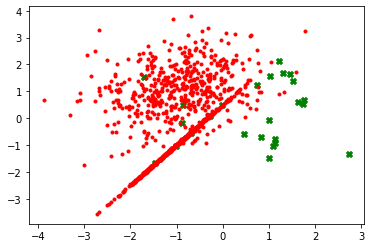

Over-sampling %:  0
Precision:  0.5
Recall:  0.16666666666666666

Over-sampling %:  0


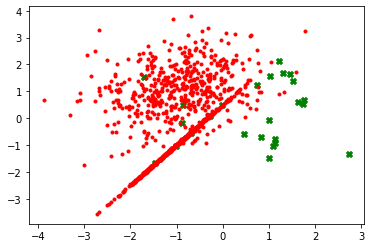

Over-sampling %:  100
Precision:  0.9090909090909091
Recall:  0.625

Over-sampling %:  100


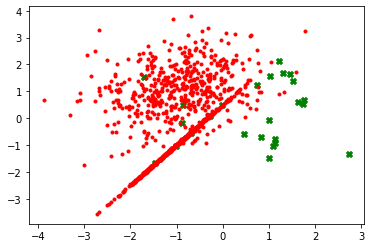

Over-sampling %:  200
Precision:  0.7368421052631579
Recall:  0.7

Over-sampling %:  200


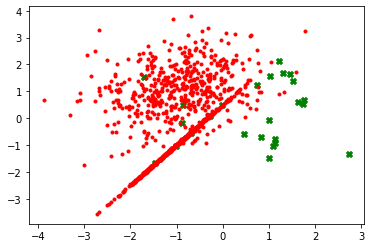

Over-sampling %:  300
Precision:  0.9230769230769231
Recall:  0.6857142857142857

Over-sampling %:  300


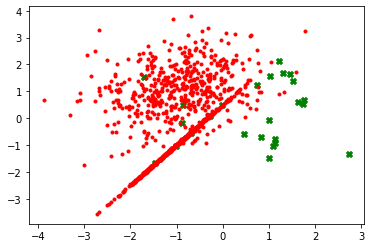

In [ ]:
for j in range(len(ir)):
  print('Imbalance Ratio: ', ir[j])
  for num_samp in number_samples:
    print('Number of Samples: ', num_samp)
    X, y = load_synthetic_dataset(num_samples=num_samp, weights_list=[ir[j]/(ir[j]+1), 1/(ir[j]+1)], random_state=2)
    for i in range(0, len(oversampling_percentage)):
      newX, newy, fpr, tpr, roc_auc = evaluate_smote(X, y, os_percent=oversampling_percentage[i])
      print('Over-sampling %: ', oversampling_percentage[i])
      plt.scatter(X[:,0][y[:,0]==1],X[:,1][y[:,0]==1],c='g',marker='X')
      plt.scatter(X[:,0][y[:, 0]==0],X[:,1][y[:, 0]==0],c='r',marker='.')
      plt.show()

#### SMOTEBoost on Synthetic Data

Imbalance Ratio:  5
Number of Samples:  1000


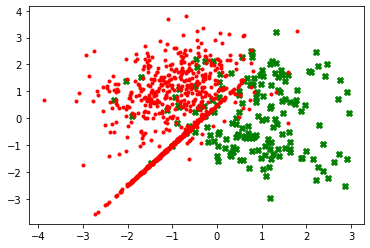


Precision:  0.6875
Recall:  0.717391304347826





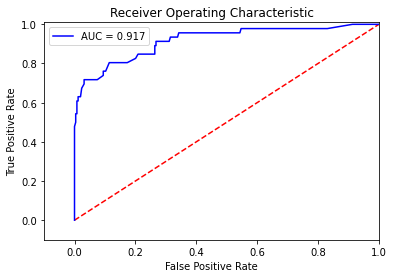

Imbalance Ratio:  10
Number of Samples:  1000


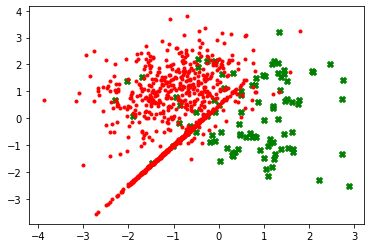


Precision:  0.4857142857142857
Recall:  0.6296296296296297





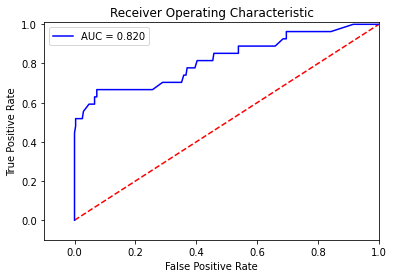

Imbalance Ratio:  50
Number of Samples:  1000


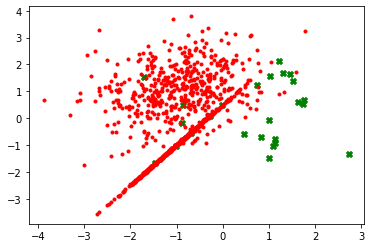


Precision:  0.1
Recall:  0.16666666666666666





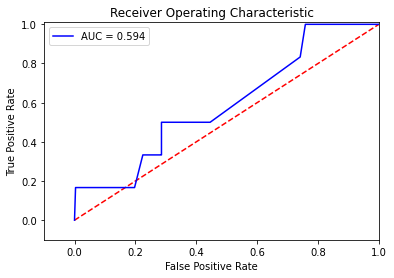

In [ ]:
for j in range(len(ir)):
  print('Imbalance Ratio: ', ir[j])
  for num_samp in number_samples:
    print('Number of Samples: ', num_samp)
    X, y = load_synthetic_dataset(num_samples=num_samp, weights_list=[ir[j]/(ir[j]+1), 1/(ir[j]+1)], random_state=2)
    plt.title('Receiver Operating Characteristic')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    fpr, tpr, roc_auc = evaluate_smote_boost(X, y)
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% (roc_auc))
    print('\n\n')

    plt.legend()
    plt.show()